In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

In [ ]:
myToken = 'ABC123.XXXXXX.84098767' # Own token from EODHistoricalData

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests

from myFunctions import *

# Set the plotting DPI settings to be a bit higher.
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

# Load X and y

In [17]:
X=pd.read_csv('filteredAnnualStockFeatures_2021.csv', index_col=0)
y=pd.read_csv('filteredAnnualStockPerformance_2021.csv', index_col=0)

# Testing Feature Selection
Do we need all the stock selection features?

In [12]:
# Features not too correlated generally 
X.corr().style.background_gradient(cmap='Reds').set_precision(3) 

,P/E,P/S,P/B,RoE,ROCE,grossProfitMargin,fixedAssetTurnover,workingAssetTurnover,workingCapitalRatio,BookEquity/TL,Debt/Equity,cashRatio,debtRatio,EV/EBIT,Op. In./(NWC+FA),Op. In./interestExpense,EBIT/TA,RE/TA,(CA-CL)/TA
P/E,1.000,0.279,0.398,0.012,0.026,-0.024,-0.050,-0.038,0.017,0.052,0.012,0.047,0.052,0.135,-0.002,0.002,0.045,0.059,-0.201
P/S,0.279,1.000,0.503,-0.031,-0.067,-0.196,0.074,-0.013,0.103,0.199,-0.029,0.139,0.199,0.054,-0.021,-0.099,-0.138,-0.143,-0.014
P/B,0.398,0.503,1.000,-0.005,-0.014,-0.005,0.016,0.011,0.039,0.027,0.193,0.055,0.027,0.058,0.001,-0.007,0.005,-0.018,-0.022
RoE,0.012,-0.031,-0.005,1.000,0.449,0.056,0.017,0.019,0.012,-0.004,-0.120,0.007,-0.004,0.009,0.144,0.110,0.256,0.104,-0.062
ROCE,0.026,-0.067,-0.014,0.449,1.000,0.126,0.017,0.008,0.029,0.023,-0.071,0.020,0.023,0.023,0.172,0.231,0.501,0.223,-0.128
grossProfitMargin,-0.024,-0.196,-0.005,0.056,0.126,1.000,0.086,-0.001,0.114,0.004,0.014,0.087,0.005,-0.028,0.034,0.132,0.208,0.173,0.024
fixedAssetTurnover,-0.050,0.074,0.016,0.017,0.017,0.086,1.000,0.036,0.299,0.198,0.006,0.251,0.198,0.015,0.036,0.174,-0.010,-0.059,0.117
workingAssetTurnover,-0.038,-0.013,0.011,0.019,0.008,-0.001,0.036,1.000,-0.001,-0.009,0.009,-0.005,-0.010,-0.003,0.143,0.009,0.017,0.011,0.062
workingCapitalRatio,0.017,0.103,0.039,0.012,0.029,0.114,0.299,-0.001,1.000,0.342,0.011,0.909,0.342,0.020,0.012,0.075,0.049,0.025,0.245
BookEquity/TL,0.052,0.199,0.027,-0.004,0.023,0.004,0.198,-0.009,0.342,1.000,-0.073,0.336,1.000,0.064,0.017,0.081,0.042,0.013,0.155


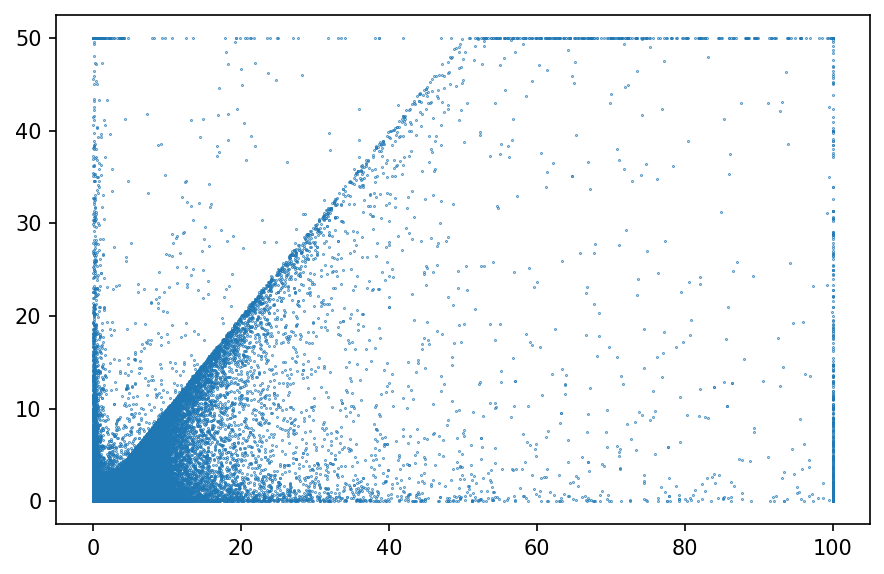

In [14]:
plt.scatter(X['workingCapitalRatio'], X['cashRatio'], s=0.1);

# Quick and Dirty Machine Learning

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.5, random_state=42)

regr = RandomForestRegressor(random_state=2, 
                             max_depth=30).fit(X_train, 
                                               np.array(y_train).ravel())
y_pred = regr.predict(X_test)

from sklearn.metrics import mean_squared_error
print('RMSE is: ', np.sqrt(mean_squared_error(y_pred, 
                                              y_test)))

RMSE is:  0.7513599588657308


<BarContainer object of 18 artists>

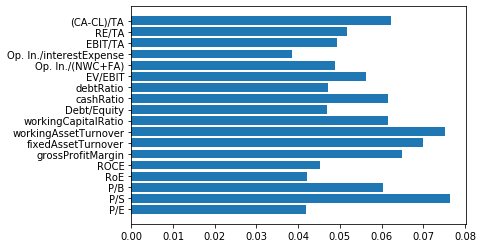

In [36]:
plt.barh(y=X.keys(),width=regr.feature_importances_);

# Use Recursive Feature Elimination (RFE)

In [52]:
from sklearn.feature_selection import RFE
selector = RFE(regr, n_features_to_select=5, step=1) # takes hours
selector = selector.fit(X, np.array(y).ravel())
selector.support_

array([False,  True, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False,  True, False,  True])

In [209]:
for i in zip(X.keys(), selector.ranking_):
    print(i)

('P/E', 11)
('P/S', 1)
('P/B', 4)
('RoE', 14)
('ROCE', 10)
('grossProfitMargin', 6)
('fixedAssetTurnover', 3)
('workingAssetTurnover', 1)
('workingCapitalRatio', 7)
('Debt/Equity', 12)
('cashRatio', 2)
('debtRatio', 1)
('EV/EBIT', 5)
('Op. In./(NWC+FA)', 8)
('Op. In./interestExpense', 13)
('EBIT/TA', 1)
('RE/TA', 9)
('(CA-CL)/TA', 1)


# Check Feature Inclusion
Check the prediction scores using 2, 5, 10 highest ranked features, and 2, 5, 10 lowest ranked features.
Compare with the 18 feature score.
Only doing this with Random Forest.

In [37]:
featAscendingImport = ['EBIT/TA','P/S','workingAssetTurnover','debtRatio',
                       '(CA-CL)/TA','cashRatio','fixedAssetTurnover',
                       'P/B','EV/EBIT','grossProfitMargin',
                       'workingCapitalRatio','Op. In./(NWC+FA)','RE/TA',
                       'ROCE','P/E','Debt/Equity','Op. In./interestExpense',
                       'RoE'] #Feature rank from RFE in order.

increasingHighestRankedFeatures=\
[featAscendingImport[:2], featAscendingImport[:5],\
 featAscendingImport[:10], featAscendingImport[:13]]

increasingLowestRankedFeatures = \
[featAscendingImport[-2:], featAscendingImport[-5:],\
 featAscendingImport[-10:], featAscendingImport[-13:]]

In [42]:
from sklearn.metrics import mean_squared_error

def testNoFeatures(listOfFeatureLists, numRuns=1):
    '''
    Goes through list of feature lists we want to check performance for, 
    and does randomforest regression.
    
    e.g. try 2 and 4 features and compare performance difference:
    [['P/S', 'RoE'], ['P/S', 'RoE', 'P/B', 'P/E']]
    
    Performance is measured as RMSE.
    
    Train/test split differs each time if many runs are done 
    to check performance consistency.
    
    Returns DataFrame of RMSE and number of features for each run.
    '''
    returnCols = ['FeaturesUsed', 'RMSE']
    rankedFeatScores = pd.DataFrame(columns=returnCols)
    
    for myFeatures in listOfFeatureLists:
        for repeatNum in range(0,numRuns):
            X_new = X[myFeatures]
            X_train, X_test, y_train, y_test = \
            train_test_split(X_new, 
                             np.array(y).ravel(), 
                             test_size=0.5, 
                             random_state=42 + repeatNum)
            
            regr = RandomForestRegressor(random_state=2, 
                                         max_depth=30).fit(X_train, y_train)
            
            y_pred = regr.predict(X_test)

            # corresponding to returnCols
            results = [len(myFeatures), 
                       np.sqrt(mean_squared_error(y_pred, y_test))]
            
            print(results)
            rankedFeatScores=\
            rankedFeatScores.append(pd.DataFrame([results], 
                                                 columns=returnCols),
                                    ignore_index=True)

    return rankedFeatScores

In [43]:
incrLowestRankedFeatScores = testNoFeatures(increasingLowestRankedFeatures, 
                                            numRuns=5)

incrHighestRankedFeatScores = testNoFeatures(increasingHighestRankedFeatures, 
                                             numRuns=5)

incrLowestRankedFeatScores.to_csv('incrLowestRankedFeatScores.csv')
incrHighestRankedFeatScores.to_csv('incHighestRankedFeatScores.csv')

[2, 0.7849263874504551]
[2, 0.7814329090663803]
[2, 0.7826091789522313]
[2, 0.7768279345519286]
[2, 0.7788616077278725]
[5, 0.7652766356953488]
[5, 0.7688032784332843]
[5, 0.7656290796790785]
[5, 0.7563884421728108]
[5, 0.7571037187374972]
[10, 0.753396745895695]
[10, 0.7588874860484559]
[10, 0.7513483946193201]
[10, 0.7443910044723347]
[10, 0.7471701383376346]
[13, 0.7522457534616578]
[13, 0.757327328618482]
[13, 0.7518813050380797]
[13, 0.7425288972258295]
[13, 0.7475707412204993]
[2, 0.7774673319129928]
[2, 0.7805308119777579]
[2, 0.7775314786913524]
[2, 0.7653025150907312]
[2, 0.7742595760178508]
[5, 0.7559715861649086]
[5, 0.7612937574200573]
[5, 0.7545336085445218]
[5, 0.7437993452363321]
[5, 0.7490607066726466]
[10, 0.7528037427666413]
[10, 0.7568804280544967]
[10, 0.7526460801680674]
[10, 0.7421170644883937]
[10, 0.7472714152290033]
[13, 0.7516762610629846]
[13, 0.7561576647639512]
[13, 0.7512887933860025]
[13, 0.7413400818906136]
[13, 0.746099179457038]


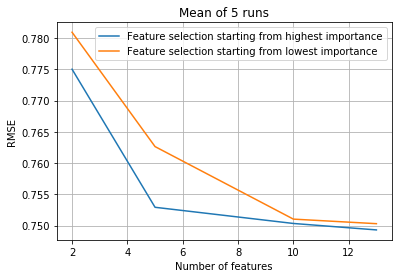

In [44]:
featFromLowestRankScores, featFromHighestRankScores = [], []
featureNumbers = [2,5,10,13]
for i in featureNumbers:
    featFromLowestRankScores.append(np.mean(\
     incrLowestRankedFeatScores[incrLowestRankedFeatScores.FeaturesUsed==i]['RMSE']))
    featFromHighestRankScores.append(np.mean(\
     incrHighestRankedFeatScores[incrHighestRankedFeatScores.FeaturesUsed==i]['RMSE']))
    
plt.plot(featureNumbers, featFromHighestRankScores, featureNumbers, featFromLowestRankScores)
plt.title('Feature Selection, Impact on Accuracy by Removing Features \nMean of 5 Runs')
plt.legend(['Feature selection starting from highest importance',\
            'Feature selection starting from lowest importance'])
plt.xlabel('Number of features')
plt.ylabel('RMSE')
plt.grid()

In [45]:
fullFeature = testNoFeatures([list(X.keys())], numRuns=5) # check the prediction score with all features.

[18, 0.7513599588657308]
[18, 0.7562568733941356]
[18, 0.7525155684428043]
[18, 0.7439064526163645]
[18, 0.7465083904634295]


In [46]:
fullFeature['RMSE'].mean()

0.7501094487564929

# Feature Transformation

In [18]:
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer()
X_t = transformer.fit_transform(X)
X_t = pd.DataFrame(X_t, columns = X.keys())

Text(0.5, 1.0, 'fixedAssetTurnover After Transformation')

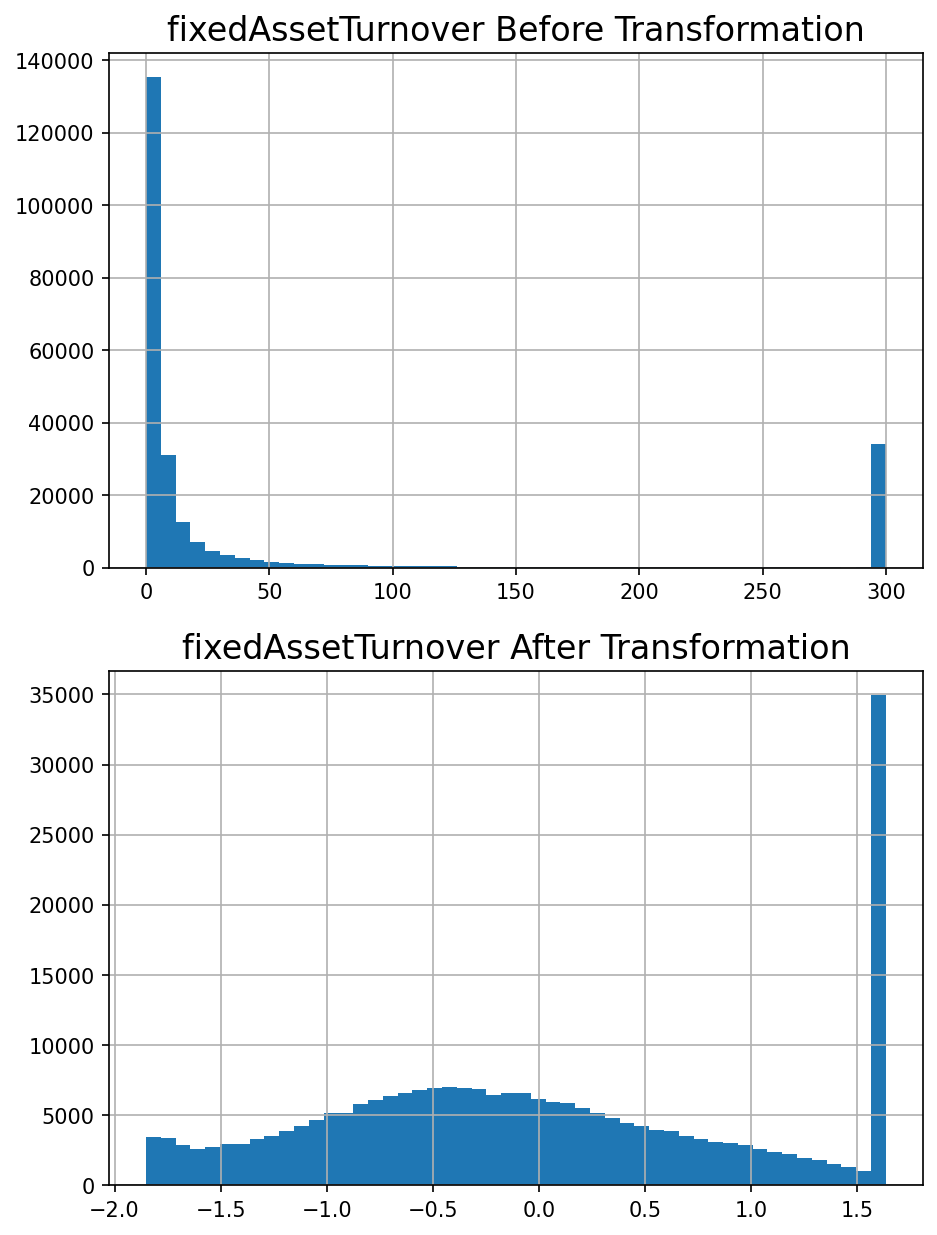

In [21]:
col = X.keys()[6] # try different columns
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
X[col].hist(bins=50);
plt.title(col+' Before Transformation', fontsize=16)
plt.subplot(2,1,2)
X_t[col].hist(bins=50);
plt.title(col+' After Transformation', fontsize=16)

In [49]:
X_t.describe().loc['max']

P/E                         2.241615
P/S                         1.985388
P/B                         4.459665
RoE                        11.744435
ROCE                        8.117921
grossProfitMargin          44.020632
fixedAssetTurnover          1.884435
workingAssetTurnover        7.633700
workingCapitalRatio         1.962677
Debt/Equity                10.731177
cashRatio                   2.003365
debtRatio                   6.548172
EV/EBIT                     5.791839
Op. In./(NWC+FA)            8.224480
Op. In./interestExpense     2.579754
EBIT/TA                    15.728195
RE/TA                      32.493779
(CA-CL)/TA                 12.970724
Name: max, dtype: float64

In [22]:
X_t.describe().loc['max']

P/E                         2.754373
P/S                         1.978099
P/B                         4.506790
RoE                        10.430965
ROCE                        7.341768
grossProfitMargin          36.270412
fixedAssetTurnover          1.634671
workingAssetTurnover        7.097990
workingCapitalRatio         2.192672
BookEquity/TL               4.353769
Debt/Equity                10.975827
cashRatio                   2.063923
debtRatio                   6.467208
EV/EBIT                     6.729981
Op. In./(NWC+FA)            8.373079
Op. In./interestExpense     2.246191
EBIT/TA                    14.987950
RE/TA                      25.767146
(CA-CL)/TA                 14.040722
Name: max, dtype: float64